In [1]:
import pandas as pd
import yfinance as yf
import yahoo_fin.stock_info as ys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix
from tqdm.auto import tqdm
import warnings
import random
import urllib
from pandas_datareader import data

plt.style.use('seaborn-deep')
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## USER FUNCTIONS

In [2]:
def get_colors():
    
    lst = ['yellowgreen', 'indianred', 'cornflowerblue', 'orchid',
          'lightseagreen', 'khaki', 'palegreen', 'mediumslateblue',
          'salmon', 'sandybrown', 'tan', 'slategrey', 'plum', 'teal',
          'goldenrod', 'firebrick', 'slateblue', 'palevioletred', 'paleturquoise',
          'turquoise', 'coral', 'navy', 'maroon', 'fuchsia', 'deepskyblue']
    
    color = random.choice(lst)
    return color


def fetch_finance_data(dct, end, SINGLEPLOT=False):
    dfl = []
    leglist = [str(key) for key in dct.keys()]

    for (i, (x, y)), l in zip(enumerate(dct.items()), leglist):
        price_rsnl = yf.download(list(dct.keys())[i], dct[x], end)
        dfl.append(price_rsnl)
        price_rsnl.Close.plot(figsize=(20, 7), lw=3, color=get_colors())
        plt.title(f'Closing Prices - {list(dct.keys())[i]}', fontsize=16)
        plt.ylabel('Closing Price in INR', fontsize=16)
        plt.xlabel('Dates', fontsize=16)
        plt.legend([l])

        
        if not SINGLEPLOT:
            plt.title(f'Closing Prices - {list(dct.keys())[i]}', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'plots/{list(dct.keys())[i]}.jpeg')
            plt.show()

        else:
            plt.tight_layout()
            plt.savefig(f'plots/plot.jpeg')

    return dfl


def get_company_basics(lst):
    
    details = {}
    
    for i, x in enumerate(lst):
        try:
            response = urllib.request.urlopen(f'https://query2.finance.yahoo.com/v1/finance/search?q={x}')
            content = response.read()
            fname = json.loads(content.decode('utf8'))['quotes'][0]['longname']
            sector = json.loads(content.decode('utf8'))['quotes'][0]['sector']
            industry = json.loads(content.decode('utf8'))['quotes'][0]['industry']
            typedisp = json.loads(content.decode('utf8'))['quotes'][0]['typeDisp']
            quotetype  = json.loads(content.decode('utf8'))['quotes'][0]['quoteType']
        
            details[x] = {'full_name': fname, 'sector': sector, 'typedisp': typedisp,
                     'quotetype': quotetype}
        except Exception as e:
            print(f'Exception in Fetching Company Basics - {e}')
        
        company_details = ys.get_quote_table(x)
    
    print(f'Basic Details: {details}')
    print(f'Company Details: {company_details}')
    
    return details, company_details



def total_capital_traded(lst, dfl, SINGLEPLOT=False):
    dfll = []
    for x, Y in enumerate(dfl):
        Y['Total Capital Traded'] = Y['Open'] * Y['Volume'] / 1e9
        Y['Total Capital Traded'].plot(label=f'{lst[x]}', figsize=(20, 7), lw=1)
        plt.legend()
        plt.ylabel('Total Traded in Billions (INR)', fontsize=16)
        plt.xlabel('Dates', fontsize=16)
        plt.title(f'Total Capital Traded - {lst[x]}', fontsize=16)
        if not SINGLEPLOT:
            plt.tight_layout()
            plt.savefig(f'plots/total-cap-traded-{lst[x]}.jpeg')
            plt.show()
        else:
            plt.tight_layout()
            plt.savefig(f'plots/total_cap_traded.jpeg')
            
        
        dfll.append(Y)
        
    return dfll



def calculate_moving_average(lst, dfl, ma1=50, ma2=200, SINGLEPLOT=False):
    dfll = []
    for x, Y in enumerate(dfl):
        plt.figure(figsize=(20, 7))
        sns.lineplot(data=Y['Open'],
                     label=f'{lst[x]} Opening', 
                     color='navy', lw=3, alpha=0.35)
        
        Y['MA50'] = Y['Open'].rolling(ma1).mean()
        sns.lineplot(data=Y['MA50'], label=f'{ma1} day Average on Open', color='forestgreen',
                     lw=2)
        
        Y['MA200'] = Y['Open'].rolling(ma2).mean()
        sns.lineplot(data=Y['MA200'], label=f'{ma2} day Average on Open', color='indianred',
                     lw=2)
        
        plt.title(f'Moving Average on Stock Prices - {lst[x]}', fontsize=16)
        plt.ylabel('Stock Price in INR', fontsize=16)
        plt.xlabel('Dates', fontsize=16)
        plt.legend()
        
        if not SINGLEPLOT:
            plt.tight_layout()
            plt.savefig(f'plots/moving-average-{lst[x]}.jpeg')
            plt.show()
        else:
            plt.tight_layout()
            plt.savefig(f'plots/moving-average.jpeg')
            
        dfll.append(Y)
    return dfll



# Volatility of Stock
def get_stock_volatility(lst, dfl, SINGLEPLOT=False, kde=0):

    dfll = []
    for x, Y in enumerate(dfl):
        Y['Daily Returns'] = Y['Close'].pct_change()
        
        
        if kde == 2:
            Y['Daily Returns'].plot(kind='kde',label=f'{lst[x]}',figsize=(20, 7), lw=1)
            plt.title(f'Stock Volatility - {lst[x]}', fontsize=16)
            plt.xlabel('Dates', fontsize=16)
            plt.ylabel('Price Jump Distribution (INR)', fontsize=16)
            plt.legend()
            if not SINGLEPLOT:
                plt.show()
                
        elif kde == 0:
            plt.figure(figsize=(20, 7))
            sns.histplot(Y['Daily Returns'], bins=50,
                     label=f'{lst[x]}', kde=True, alpha=0.5, lw=1)
            plt.title(f'Stock Volatility - {lst[x]}', fontsize=16)
            plt.xlabel('Dates', fontsize=16)
            plt.ylabel('Price Jump Distribution (INR)', fontsize=16)
            plt.legend()
            if SINGLEPLOT:
                plt.show()
        
        elif kde == 1:
            plt.figure(figsize=(20, 7))
            sns.histplot(Y['Daily Returns'], bins=50,
                     label=f'{lst[x]}', kde=False, alpha=0.5, lw=1)      
            plt.title(f'Stock Volatility - {lst[x]}', fontsize=16)
            plt.xlabel('Dates', fontsize=16)
            plt.ylabel('Price Jump Distribution (INR)', fontsize=16)
            plt.legend()
            if SINGLEPLOT:
                plt.tight_layout()
                plt.savefig(f'plots/stock-volatility-{lst[x]}.jpeg')
                plt.show()
            else:
                plt.tight_layout()
                plt.savefig(f'plots/stock-volatility.jpeg')
            
        else:
            None
    
        dfll.append(Y)
        
    return dfll


def get_daily_returns_pc(lst, dfl, SINGLEPLOT=False):
    dfll = []
    for x, Y in enumerate(dfl):
        Y['Daily Returns'] = Y['Close'].pct_change()
   
        plt.figure(figsize=(20, 7))
        plt.scatter(Y.index, Y['Daily Returns'], color=get_colors(),
                   lw=1, label=f'{lst[x]} Daily Returns')
        
        plt.title(f'Daily Return Percentage (%) {lst[x]}', fontsize=16)
        plt.ylabel('Change in %', fontsize=16)
        plt.xlabel('Dates', fontsize=16)
        plt.legend()
        if not SINGLEPLOT:
            plt.tight_layout()
            plt.savefig(f'plots/daily-pc-returns-{lst[x]}.jpeg')
            plt.show()
        else:
            plt.tight_layout()
            plt.savefig(f'plots/dail_pc_returns.jpeg')
            
        dfll.append(Y)
        
    return dfll



def get_volatility_boxplot(lst, dfl):
    
    series_list = [df['Daily Returns'] for df in dfl]

    bdf = pd.concat(series_list, axis=1)
    bdf.columns = lst
    bdf.plot(kind='box',figsize=(20, 7), color=get_colors())
    plt.title(f'Volatility Index - {lst}', fontsize=16)
    plt.ylabel('Volatility Index', fontsize=16)
    plt.xlabel('Dates', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/boxplot-volatility.jpeg')
    plt.show()
    return None



def get_correlation_analysis(lst, dfl):
    
    series_list = [df['Daily Returns'] for df in dfl]

    bdf = pd.concat(series_list, axis=1)
    bdf.columns = lst
    
    scatter_matrix(bdf, figsize=(10, 10), hist_kwds={'bins':50}, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'plots/correlation-plot.jpeg')
    plt.show()
    
    return None
    
    

def get_cumulative_returns(lst, dfl, SINGLEPLOT=False):
    dfll = []
    for x, Y in enumerate(dfl):
        Y['Cumulative Returns'] = (1 + Y['Daily Returns']).cumprod()
        plt.figure(figsize=(20, 7))
        sns.lineplot(data=Y['Cumulative Returns'], label=f'{lst[x]}', lw=3, color=get_colors())
        plt.title(f'Cumulative Returns vs Time - {lst[x]}', fontsize=16)
        plt.ylabel('Return Factor', fontsize=16)
        plt.xlabel('Dates', fontsize=16)
        plt.legend()
        if not SINGLEPLOT:
            plt.title(f'Cumulative Returns vs Time - {lst[x]}', fontsize=16)
            plt.ylabel('Return Factor', fontsize=16)
            plt.xlabel('Dates', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'plots/get-cum-returns-{lst[x]}.jpeg')
            plt.show()
        else:
            plt.tight_layout()
            plt.savefig(f'plots/get-cum-returns.jpeg')
            
        dfll.append(Y)
    return dfll



def get_sharpe_ratio(lst, dfl):
    
    dfll = []
    # 2% interest over 252 trading days in a year
    risk_free_rate = 0.02 / 252 
    
    for x, Y in enumerate(dfl):
    
        Y['Excess_Returns'] = Y['Daily Returns'] - risk_free_rate

        sharpe_ratio = np.sqrt(252) * Y['Excess_Returns'].mean() / Y['Excess_Returns'].std()
        sharpe_ratio2 = np.sqrt(252) * (Y['Daily Returns'].mean() - risk_free_rate) / Y['Daily Returns'].std()

        sr = (sharpe_ratio + sharpe_ratio) / 2
        print(f'{lst[x]} - Sharpe Ratio: {round(sr, 3)}')
        
        dfll.append(Y)
        
    return dfll, sr



def analyze_risk_returns(lst, dfl):

    # Risk Analysis
    dhol = []
    for x in range(len(dfl)):
        closing_df = pd.DataFrame(dfl[x]['Close'])
        close = closing_df.rename(columns={"Close": f"{lst[x]}_close"})

        dhol.append(close)

    closing_df = pd.concat(dhol, axis=1)

    tech_returns = closing_df.pct_change()

    rets = tech_returns.dropna()

    plt.figure(figsize=(20, 7))

    area = np.pi*20
    plt.scatter(rets.mean(), rets.std(), alpha=0.5, s=area, color='black')

    # Set the plot axis titles
    plt.xlabel('Expected returns', fontsize=16)
    plt.ylabel('Risk', fontsize=16)
    plt.xlabel('Exected Returns', fontsize=16)
    plt.title('Risk Versus Returns', fontsize=16)
    

    # Set the x and y limits of the plot

    hol = []
    df = tech_returns
    for x in df.columns:
        mx = df[x].max()
        mn = df[x].min()
        hol.append(mx)
        hol.append(mn)


    plt.ylim([0.01, 0.05])
    plt.xlim([-0.005, 0.005])

    for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
        plt.annotate(
            label,
            xy=(x, y), xytext=(50, 50),
            textcoords='offset points', ha='right', va='bottom',
            arrowprops=dict(arrowstyle='<-', connectionstyle='arc3, rad=-0.3', color='navy'),
                            color='purple')
    plt.tight_layout()
    plt.savefig(f'plots/risk-returns-plot.jpeg')
    plt.show()

    return rets




# SINGLE STOCK ANALYSIS


def returns_heatmap(df, lst):
    
    df['Month'] = [i.month for i in df.index]
    df['Year'] = [i.year for i in df.index]

    result = df.groupby(['Year', 'Month'])

    openprice = pd.DataFrame(result.Open.apply(lambda x: x.iloc[0]).reset_index())
    closeprice = pd.DataFrame(result.Close.apply(lambda x: x.iloc[-1]).reset_index())

    mdf = pd.merge(openprice, closeprice, how='left', on=['Year', 'Month'])

    mdf['Returns'] = 100 * (mdf.Close - mdf.Open) / mdf.Open
    mdf = mdf[['Year', 'Month', 'Returns']]
    mdf = mdf.pivot(index='Year', columns='Month', values='Returns')
    mdf = mdf.fillna(0)
    mdf.columns = ['Jan', 'Feb', 'March', 'April', 'May',
                   'June', 'July', 'Aug', 'Sept', 'Oct',  'Nov', 'Dec']



    fig, ax = plt.subplots(figsize=(12,8))
    sns.heatmap(mdf, annot=mdf.values, vmax=10, vmin=-10, square=True,
               cmap='RdYlGn', lw=0.3, annot_kws={'fontsize': 10})
    plt.title(f'{lst} - Monthly Returns Heatmap (%)', fontsize=16)
    plt.ylabel('Year', fontsize=16)
    plt.xlabel('Months', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/{lst}-monthly-returns-heatmap.jpeg')    
    plt.show()
    
    averages = {}
    for x in mdf.index.tolist():
        averages[x] = mdf.loc[x].mean()
    
    return df, mdf, averages



def plot_trading_assist_mfi(df, period=14, u1=80, u2=90, l1=10, l2=20):
    '''
    The Money Flow Index (MFI) is a technical indicator that generates 
    overbought or oversold signals using both prices and volume data.
    An MFI reading above 80 is considered overbought and an MFI reading 
    below 20 is considered oversold, although levels of 90 and 10 are 
    also used as thresholds. A divergence between the indicator and price 
    is noteworthy. 
    
    For example, if the indicator is rising while the price is
    falling or flat, the price could start rising.
    '''
    
    
    
    def get_money_flow_index(df):
    
        tp = (df.Close + df.High + df.Low) / 3
        mf = tp * df.Volume

        # tp = typical price
        # Get positive and negative money flows (mf)

        pf = []
        nf = []

        for i in range(1, len(tp)):
            if tp[i] > tp[i-1]:
                pf.append(mf[i-1])
                nf.append(0)
            elif tp[i] < tp[i-1]:
                pf.append(0)
                nf.append(mf[i-1])
            else:
                pf.append(0)
                nf.append(0)

        # pmf, nmf positive negative money flow    
        pmf = []
        nmf = []

        for i in range(period-1, len(pf)):
            pmf.append(sum(pf[i+1 - period:i+1]))

        for i in range(period-1, len(nf)):
            nmf.append(sum(nf[i+1 - period:i+1]))

        # Calculate Money flow index MFI
        mfi = 100 * (np.array(pmf) / (np.array(pmf) + np.array(nmf)))

        return mfi

    ndf = pd.DataFrame()
    ndf = df[period:]

    ndf['MFI'] = get_money_flow_index(df)
    

    def get_signal(data, high, low):
        bs = []
        ss = []

        for i in range(len(data.MFI)):
            if data.MFI[i] > high:
                bs.append(np.nan)
                ss.append(data.Close[i])
            elif data.MFI[i] < low:
                ss.append(np.nan)
                bs.append(data.Close[i])
            else:
                bs.append(np.nan)
                ss.append(np.nan)

        return (bs, ss)

    ndf['Buy'] = get_signal(ndf, 70, 30)[0]
    ndf['Sell'] = get_signal(ndf, 70, 30)[1]
    
    plt.figure(figsize=(20, 7))
    plt.plot(ndf.Close, label='Close Price', alpha=0.8, lw=2, color='indigo')
    plt.scatter(ndf.index, ndf.Buy, color='limegreen', label='Buy', marker='^', alpha=1)
    plt.scatter(ndf.index, ndf.Sell, color='red', label='Sell', marker='v', alpha=1)
    plt.title(f'Money Flow Index Trading Strategy - {lst}', fontsize=16)
    plt.xlabel('Dates', fontsize=16)
    plt.ylabel('Close Price (INR)', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/mfi-based-trading-indicators-{lst[0]}.jpeg')
    plt.show()
    
    plt.figure(figsize=(20, 7))
    plt.plot(ndf.MFI, label='MFI', lw=2, color='indigo', alpha=0.75)
    plt.axhline(l1, ls='--', color='orange', lw=1)
    plt.axhline(l2, ls='--', color='blue', lw=1)
    plt.axhline(u1, ls='--', color='blue', lw=1)
    plt.axhline(u2, ls='--', color='orange', lw=1)
    plt.title(f'MONEY FLOW INDEX - {lst} ', fontsize=16)
    plt.ylabel('MFI - Overbought/Oversold', fontsize=16)
    plt.xlabel('Dates', fontsize=16)
    plt.legend(['Closing Price', 'Upper Cut-off', 'High', 'Lower Cut-off', 'Low'], loc='upper left')
    plt.tight_layout()
    plt.savefig(f'plots/money-flow-index-plot-{lst[0]}.jpeg')
    plt.show()
    
    return ndf


# ndf = plot_trading_assist_mfi(df)


def plot_trading_assist_boll(df, lst, period=50):

    df['STD'] = df.Close.rolling(period).std()
    df['Upper'] = df['MA50'] + (df['STD'] * 2)
    df['Lower'] = df['MA50'] - (df['STD'] * 2)

    column_list = ['Close', 'MA50', 'Upper', 'Lower']

    new_df = df[period-1:]

    def get_signal(df):

        bs = []
        ss = []

        for i in range(len(df.Close)):
            if df.Close[i] > df.Upper[i]:
                bs.append(np.nan)
                ss.append(df.Close[i])
            elif df.Close[i] < df.Lower[i]:
                bs.append(df.Close[i])
                ss.append(np.nan)
            else:
                bs.append(np.nan)
                ss.append(np.nan)

        return (bs, ss)

    new_df['Buy'] = get_signal(new_df)[0]
    new_df['Sell'] = get_signal(new_df)[1]

    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(1, 1, 1)
    x_axis = new_df.index
    ax.fill_between(x_axis, new_df.Upper, new_df.Lower, color='ghostwhite')
    ax.plot(x_axis, new_df.Close, color='indigo', lw=2, label='Close Price', alpha=0.8)
    ax.plot(x_axis, new_df.MA50, color='darkviolet', lw=1, label='MA50 Trend', alpha=0.75, ls='--')
    ax.scatter(x_axis, new_df.Buy, color='limegreen', label='Buy', marker='^', alpha=1)
    ax.scatter(x_axis, new_df.Sell, color='red', label='Sell', marker='v', alpha=1)
    plt.ylabel('Closing Price (INR)', fontsize=16)
    plt.xlabel('Dates', fontsize=16)
    plt.title(f'Bollinger Trading Strategy - {lst}', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/bollinger-trading-indicator-{lst[0]}.jpeg')
    plt.show()
    
    return df



def plot_double_crossover_strategy(df, lst):
    
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(1, 1, 1)
    x_axis = df.index
    ax.fill_between(x_axis, df.MA50, df.MA200, color='ghostwhite')
    
    
    df['Signal'] = 0
    
    df.loc[(df.MA50 <= df.MA200) & (df.MA50.shift(1) > df.MA200.shift(1)), 'Signal'] = -1
    df.loc[(df.MA50 >= df.MA200) & (df.MA50.shift(1) < df.MA200.shift(1)), 'Signal'] = 1
    
    df = df.dropna()
    
    plt.plot(df.Close, label='Closing Price', alpha=1, color='slateblue', lw=1.5)
    plt.plot(df.MA50, label='MA50 Trend', alpha=1, color='forestgreen', lw=1, ls='--')
    plt.plot(df.MA200, label='MA200 Trend', alpha=1, color='salmon', lw=1, ls='--')
    
    plt.plot(df[df.Signal == 1].index, df.Close[df.Signal== 1], '^', color='lime', label='Buy')
    plt.plot(df[df.Signal == -1].index, df.Close[df.Signal== -1], 'v', color='red', label='Sell')
    
    plt.title(f'Double Cross Over Trading Strategy - {lst}', fontsize=16)
    plt.ylabel('Stock Price (INR)', fontsize=16)
    plt.xlabel('Dates', fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/double_crossover_strategy-{lst}.jpeg')
    plt.show()
    
    return df


def MACD_trading_strategy(df, lst):
    
    sema = df.Close.ewm(span=14, adjust=False).mean()
    lema = df.Close.ewm(span=50, adjust=False).mean()
    MACD = sema - lema
    signal = MACD.ewm(span=9, adjust=False).mean()
    
    plt.figure(figsize=(20, 7))
    plt.plot(df.index, MACD, label='MACD', color=get_colors(), lw=3)
    plt.plot(df.index, signal, label='MACD Exponential Signal', color='dimgray', lw=1, ls='--')
    plt.xlabel('Dates', fontsize=16)
    plt.title(f'MACD Strategy - {lst}')
    plt.legend()
    plt.tight_layout()
    plt.show
    
    df['MACD'] = MACD
    df['SignalLine'] = signal
    
    def buy_sell(signal):
        buy = []
        sell= []
        
        flag = -1
        
        for i in range(0, len(signal)):
            if df['MACD'][i] > df['SignalLine'][i]:
                sell.append(np.nan)
                if flag != 1:
                    buy.append(df.Close[i])
                    flag = 1
                else:
                    buy.append(np.nan)
            elif df['MACD'][i] < df['SignalLine'][i]:
                buy.append(np.nan)
                if flag != 0:
                    sell.append(df.Close[i])
                    flag = 0
                else:
                    sell.append(np.nan)
            else:
                buy.append(np.nan)
                sell.append(np.nan)
    
        return (buy, sell)
    
    a = buy_sell(df)
    df['Buy_Signal_price'] = a[0]
    df['Sell_Signal_price'] = a[1]
    
    plt.figure(figsize=(20, 7))    
    plt.scatter(df.index, df.Buy_Signal_price, color='lime', label='Buy', marker='^', alpha=1)
    plt.scatter(df.index, df.Sell_Signal_price, color='red', label='Sell', marker='v', alpha=1)
    plt.plot(df.Close, label='Close Price', alpha=0.85, lw=2, color='indigo')
    plt.xlabel('Dates', fontsize=16)
    plt.title(f'MACD Trading Strategy - {lst}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/MACD-strategy-{lst}.jpeg')
    plt.show()
    
    return df

# INFERENCE 

Multi Stock Analysis: ['ICICIBANK.NS']
Single Stock Analysis: ICICIBANK.NS


Generating Insights:   0%|          | 0/18 [00:00<?, ?it/s]

['ICICIBANK.NS']
[*********************100%%**********************]  1 of 1 completed


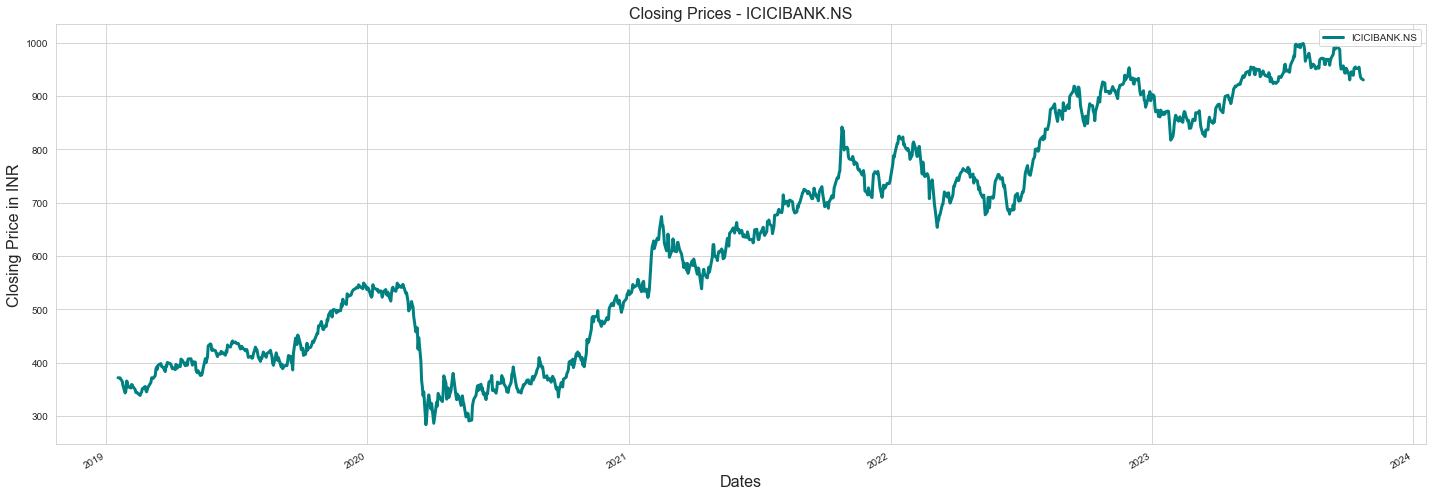

Basic Details: {'ICICIBANK.NS': {'full_name': 'ICICI Bank Limited', 'sector': 'Financial Services', 'typedisp': 'Equity', 'quotetype': 'EQUITY'}}
Company Details: {'1y Target Est': 788.07, '52 Week Range': '796.00 - 1,008.70', 'Ask': '0.00 x 0', 'Avg. Volume': 15948290.0, 'Beta (5Y Monthly)': nan, 'Bid': '0.00 x 0', "Day's Range": '925.40 - 944.80', 'EPS (TTM)': 52.33, 'Earnings Date': 'Jan 19, 2024 - Jan 23, 2024', 'Ex-Dividend Date': 'Aug 09, 2023', 'Forward Dividend & Yield': '8.00 (0.85%)', 'Market Cap': '6.514T', 'Open': 942.0, 'PE Ratio (TTM)': 17.77, 'Previous Close': 932.75, 'Quote Price': 929.9500122070312, 'Volume': 11851316.0}


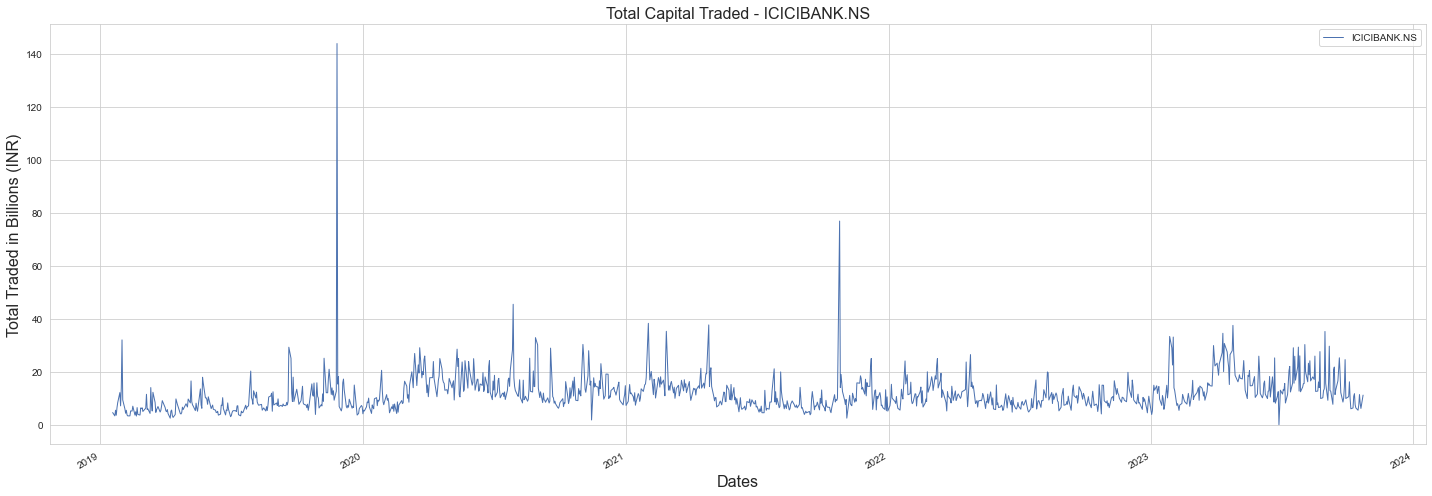

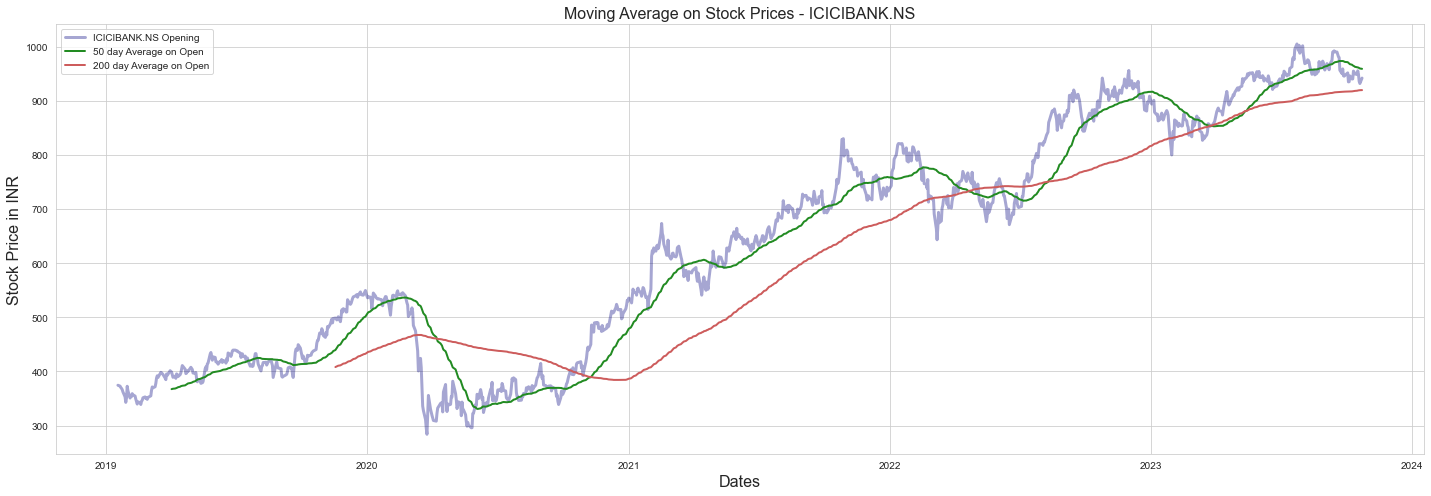

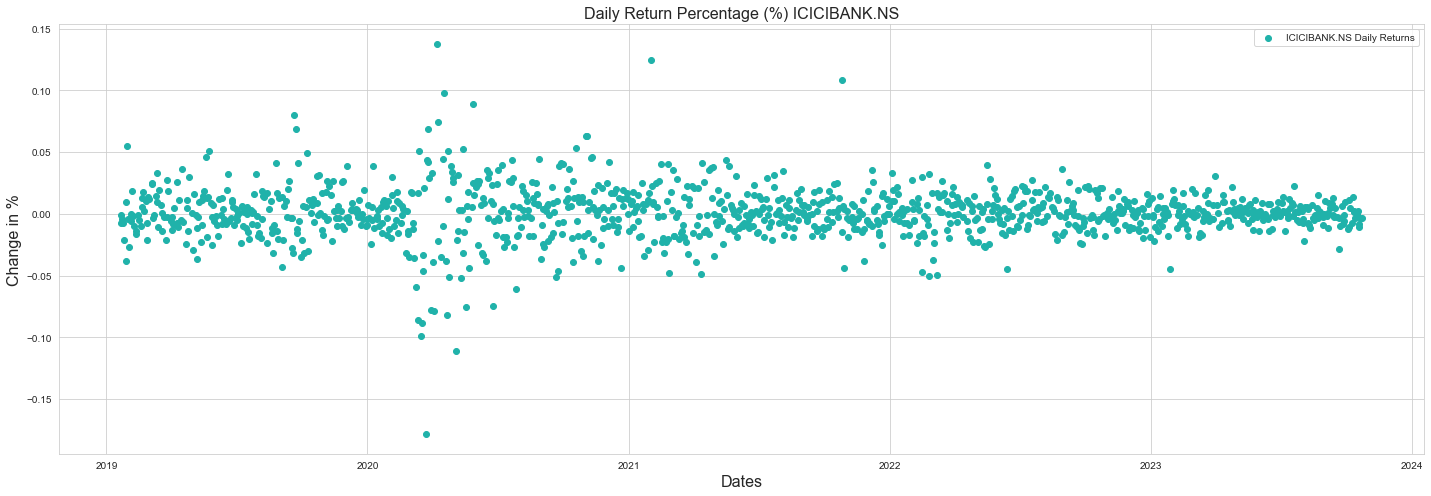

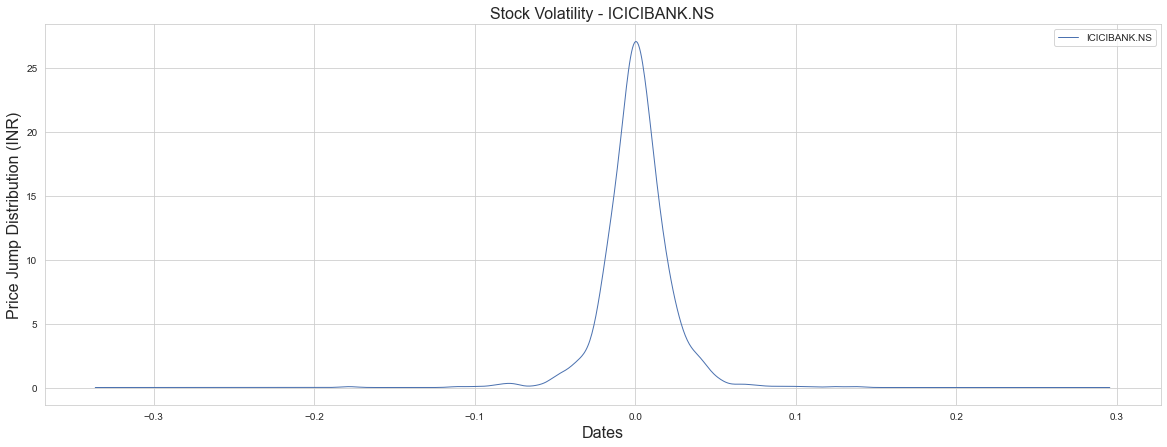

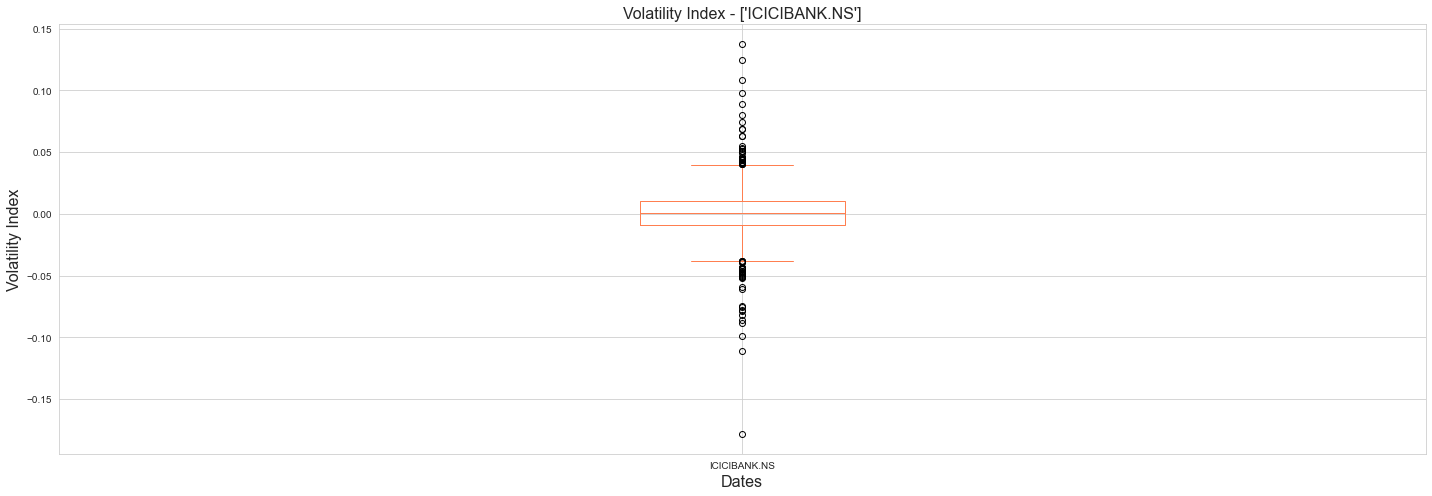

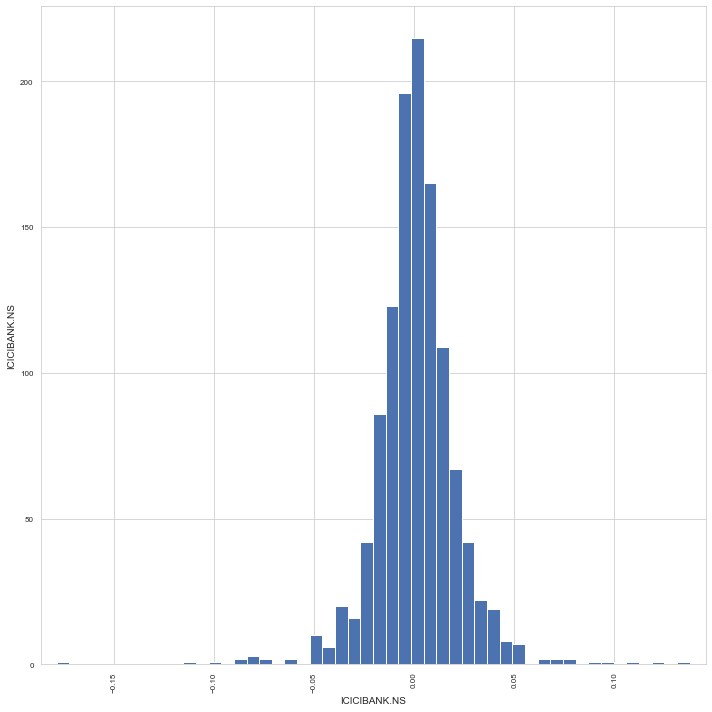

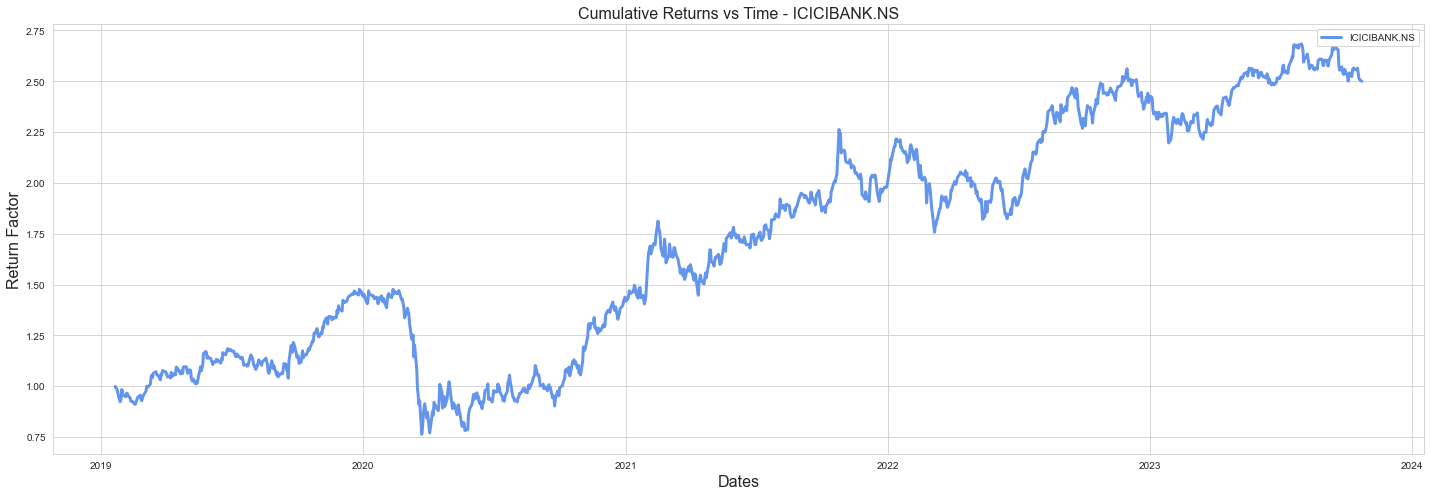

ICICIBANK.NS - Sharpe Ratio: 0.695


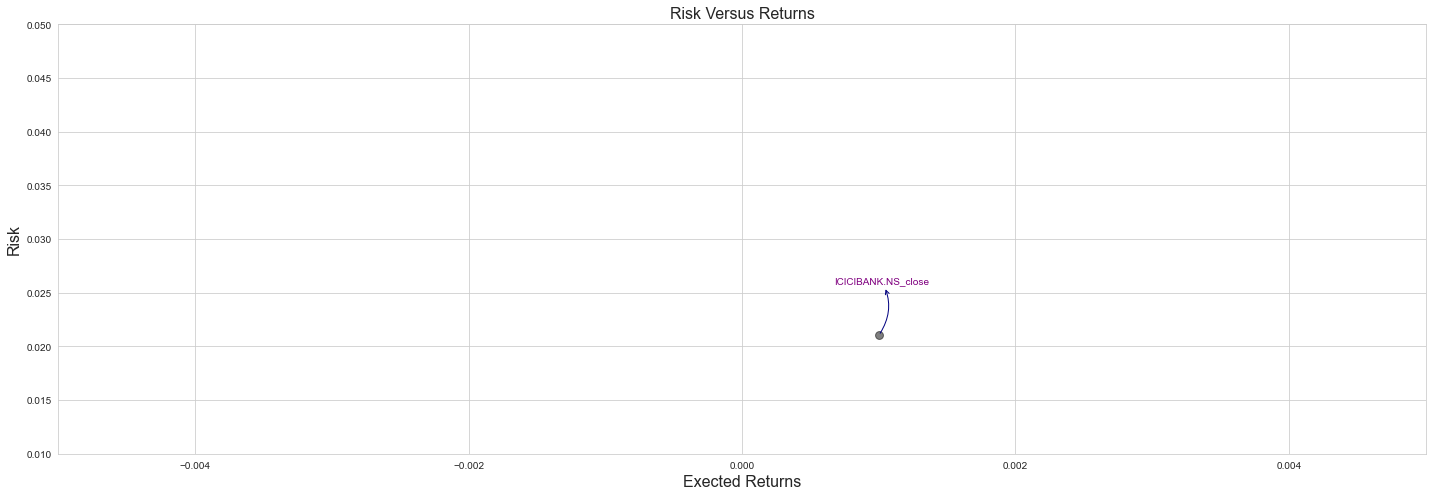

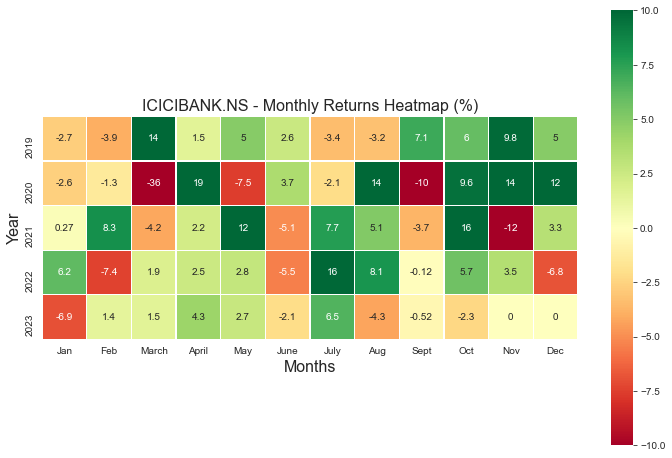

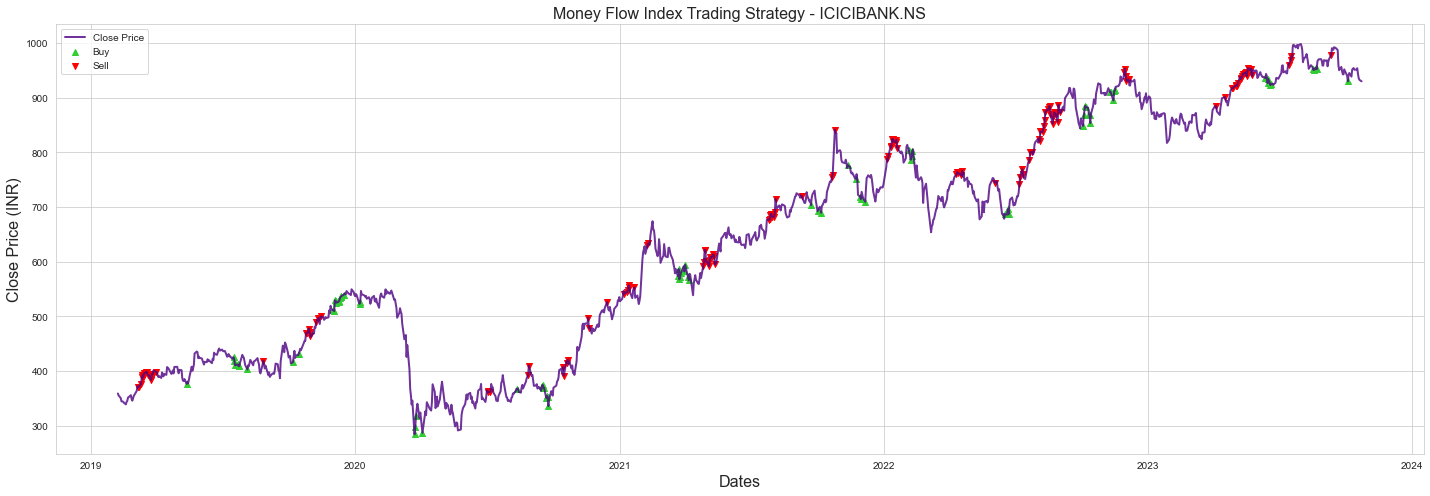

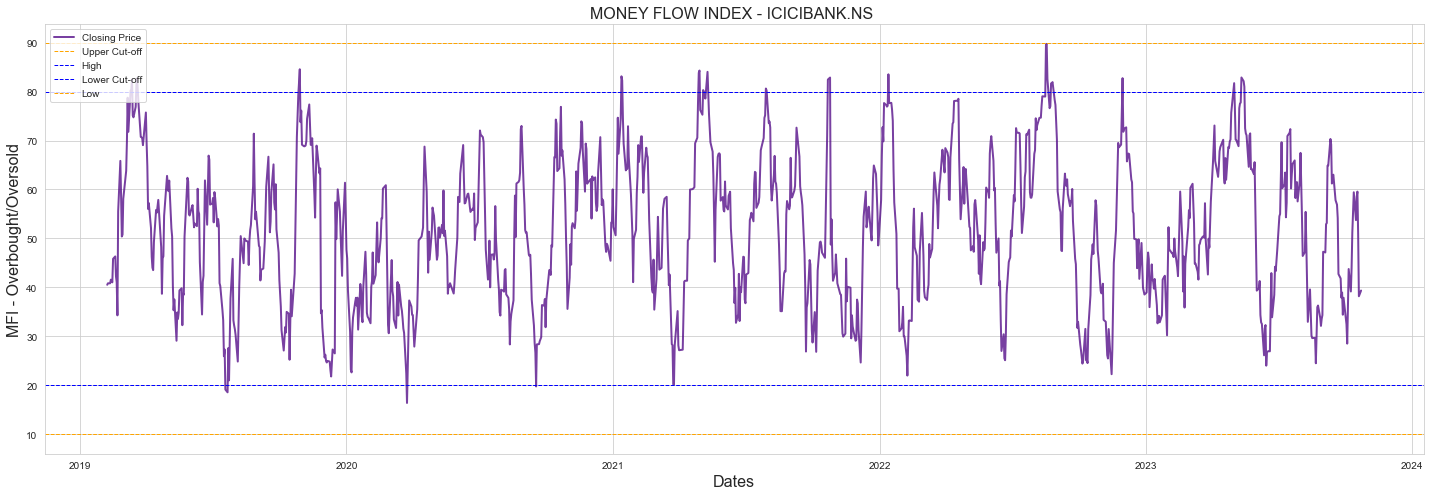

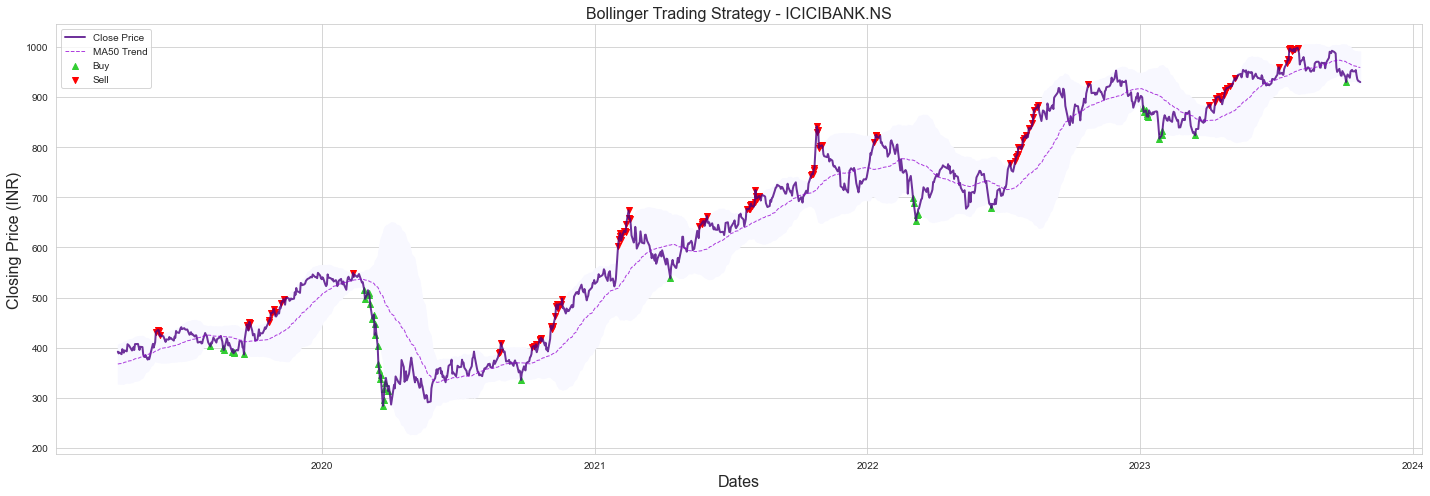

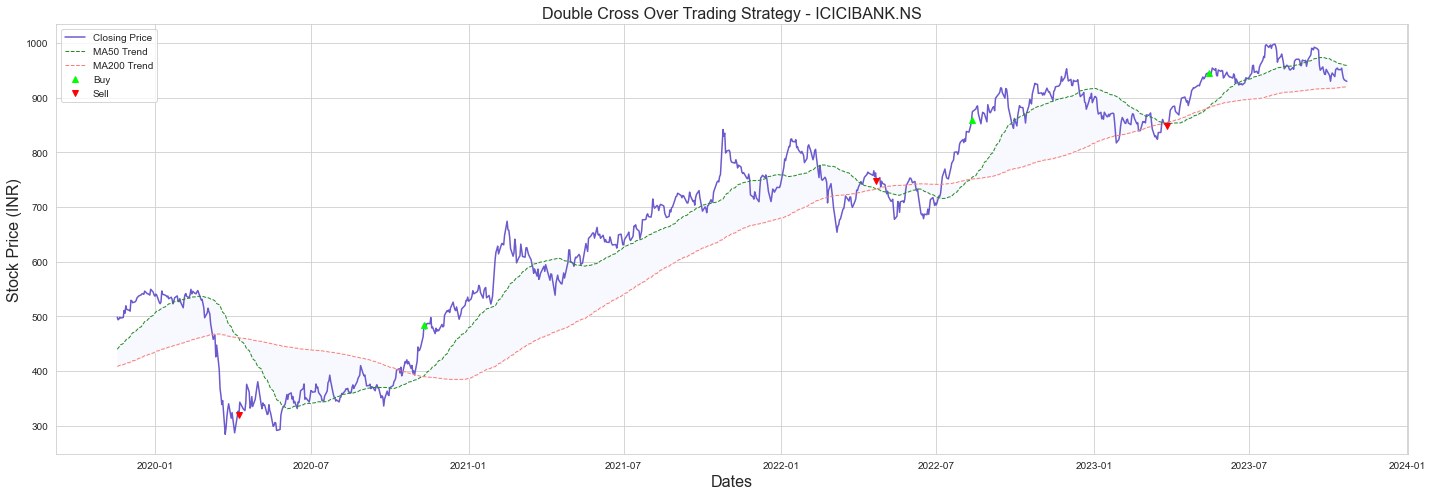

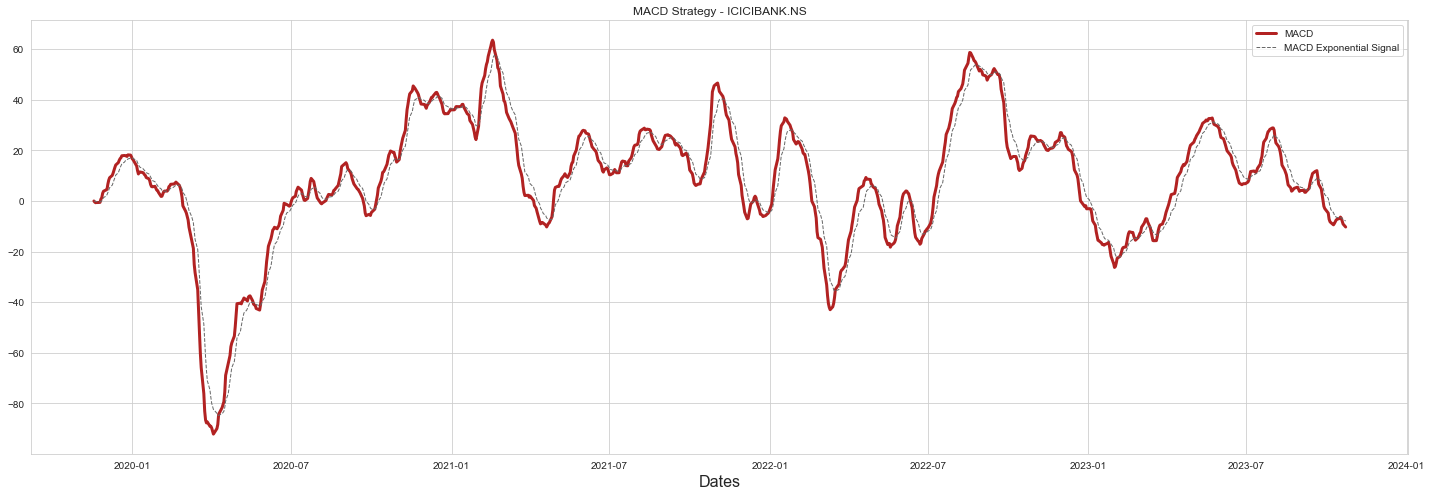

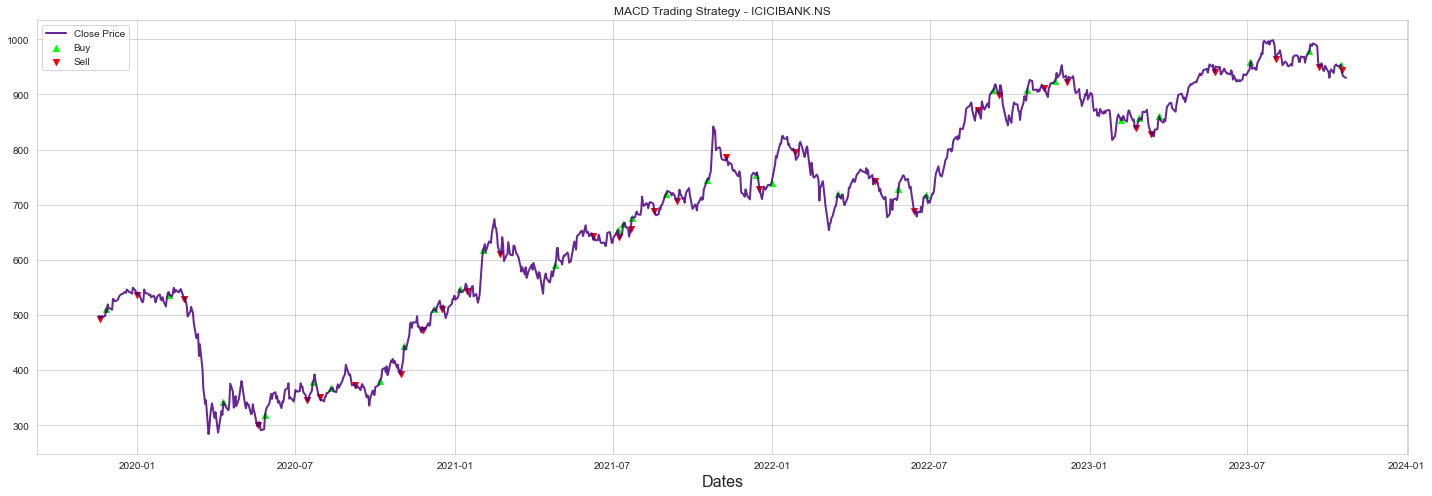

In [3]:
today = datetime.datetime.now()

# stock_dict = {'HAPPSTMNDS.NS': datetime.datetime(2022, 4, 18),
#              'RELIANCE.NS': datetime.datetime(2019, 7, 11),
#              'UJJIVAN.NS': datetime.datetime(2020, 8, 2)}

# stock_dict = {'SBIN.NS': datetime.datetime(2022, 4, 18),
#              'AXISBANK.NS': datetime.datetime(2019, 7, 11),
#              'ICICIBANK.NS': datetime.datetime(2020, 8, 2)}

stock_dict = {'ICICIBANK.NS': datetime.datetime(2019, 1, 18)}

stock_list = [str(key) for key in stock_dict.keys()]

index = 0
# df = stockdflist[index]
lst = stock_list[index]
    
print(f'Multi Stock Analysis: {stock_list}')
print(f'Single Stock Analysis: {lst}')

with tqdm(total=18, desc=f"Generating Insights") as pbar:
    
    # Multi Stock Analysis
    stockdflist = fetch_finance_data(stock_dict, today, SINGLEPLOT=False)
    df = stockdflist[0]
    pbar.update(1)
    
    infodict = get_company_basics(stock_list)
    pbar.update(1)
    
    retlist = total_capital_traded(stock_list, stockdflist, SINGLEPLOT=False)  
    pbar.update(1)
    
    retlist = calculate_moving_average(stock_list, retlist)
    pbar.update(1)
    
    retlist = get_daily_returns_pc(stock_list, retlist)
    pbar.update(1)
    
    retlist = get_stock_volatility(stock_list, retlist, SINGLEPLOT=True, kde=2)
    pbar.update(1)
    
    get_volatility_boxplot(stock_list, retlist)
    pbar.update(1)
    
    get_correlation_analysis(stock_list, retlist)
    pbar.update(1)
    
    retlist = get_cumulative_returns(stock_list, retlist, SINGLEPLOT=False)
    pbar.update(1)
    
    retlist, sharpe_ratio = get_sharpe_ratio(stock_list, retlist)
    pbar.update(1)
    
    trd = analyze_risk_returns(stock_list, retlist)
    pbar.update(1)
   
    # Single Stock Analysis
    
    df, mdf, averages = returns_heatmap(df,lst)
    pbar.update(1)
    
    ndf = plot_trading_assist_mfi(df)
    pbar.update(2)
    
    df = plot_trading_assist_boll(df, lst)
    pbar.update(1)
    
    df = plot_double_crossover_strategy(df, lst)
    pbar.update(1)
    
    df = MACD_trading_strategy(df, lst)
    pbar.update(2)